In [27]:
import numpy as np,pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [29]:
from pygam import (s as s_gam,
                    l as l_gam,
                    f as f_gam,
                    LinearGAM,
                    LogisticGAM)
from ISLP.transforms import (BSpline,
                            NaturalSpline)
from ISLP.models import bs , ns
from ISLP.pygam import (approx_lam,degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

#### Polynomial Regression and Step Functions

In [44]:
wage=load_data('Wage')
y=wage['wage']
age=wage['age']

In [46]:
poly_age=MS([poly('age',degree=4)]).fit(Wage)
M=sm.OLS(y,poly_age.transform(wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [48]:
 age_grid = np.linspace(age.min(),
 age.max(),
 100)
 age_df = pd.DataFrame({'age': age_grid})

In [50]:
def plot_wage_fit(age_df,
                  basis,
                  title):
    X=basis.transform(Wage)
    Xnew=basis.transform(age_df)
    M=sm.OLS(y,X).fit()
    preds=M.get_prediction(Xnew)
    bands=preds.conf_int(alpha=0.05)
    fig,ax=subplots(figsize=(8,8))
    ax.scatter(age,
                Y,
    facecolor='gray',
    alpha=0.5)
    for val , ls,in zip([preds.predicted_mean,
                         bands[:,0],
                         bands[:,1]],
                         ['b','r--','r--']
                         ):
        ax.plot(age_df.values,val,ls,linewidth=3)
    ax.set_title(title,fontsize=20)
    ax.set_xlabel('Age',fontsize=20)
    ax.set_ylabel('Wage',fontsize=20);
    return ax


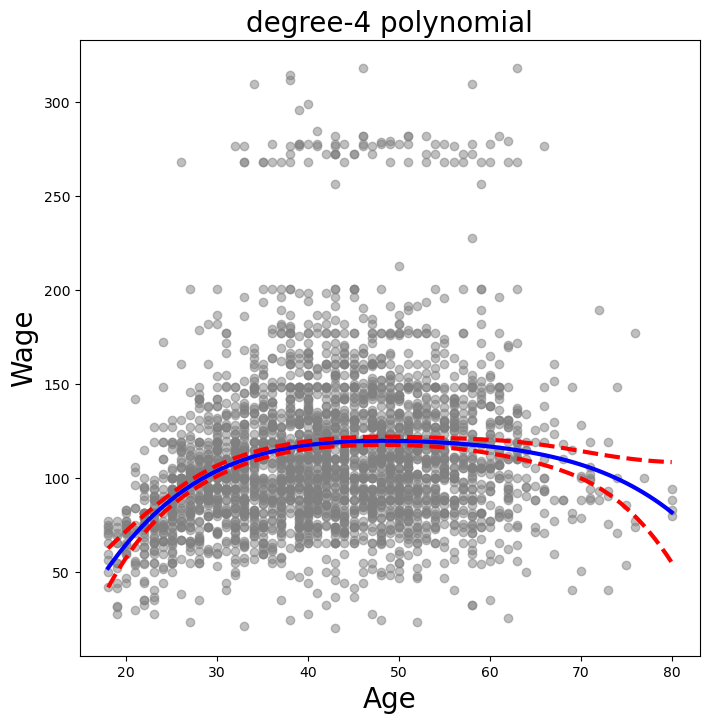

In [52]:
plot_wage_fit(age_df,poly_age,
              'degree-4 polynomial');

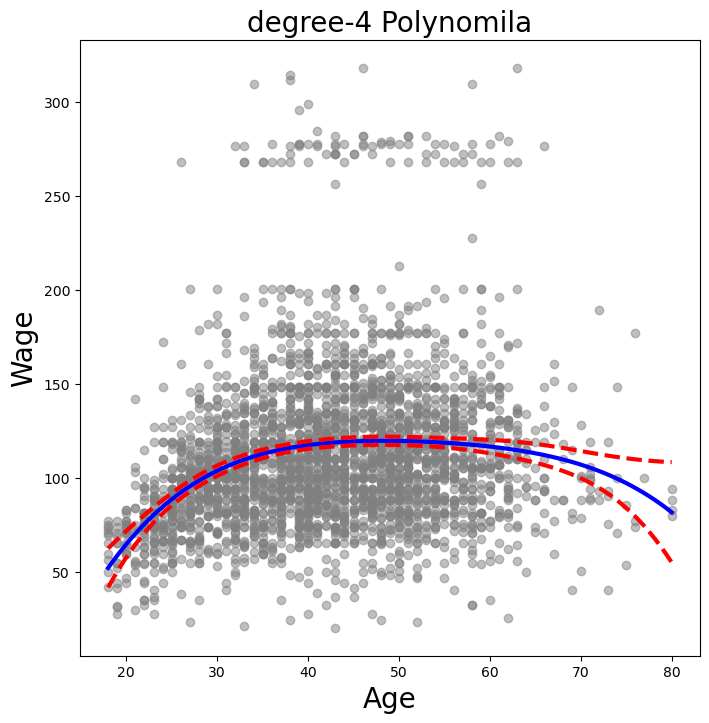

In [53]:
plot_wage_fit(age_df,
              poly_age,
              'degree-4 Polynomila');

In [56]:
models=[MS([poly('age',degree=d)])
        for d in range (1,6)]
Xs=[model.fit_transform(Wage)for model in models]
anova_lm(*[sm.OLS(y,X_).fit()
        for X_  in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [58]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [60]:
(-11.983)**2

143.59228900000002

In [62]:
models=[MS(['education',poly('age',degree=d)])
        for d in range(1,4)]
XEs=[model.fit_transform(Wage)
     for model in models]
anova_lm(*[sm.OLS(y,X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [64]:
X=poly_age.transform(Wage)
high_earn=Wage['high_earn']=y>250
glm =sm.GLM(y>250,
            X,
            family=sm.families.Binomial())
B=glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [66]:
newX=poly_age.transform(age_df)
preds=B.get_prediction(newX)
bands=preds.conf_int(alpha=0.05)

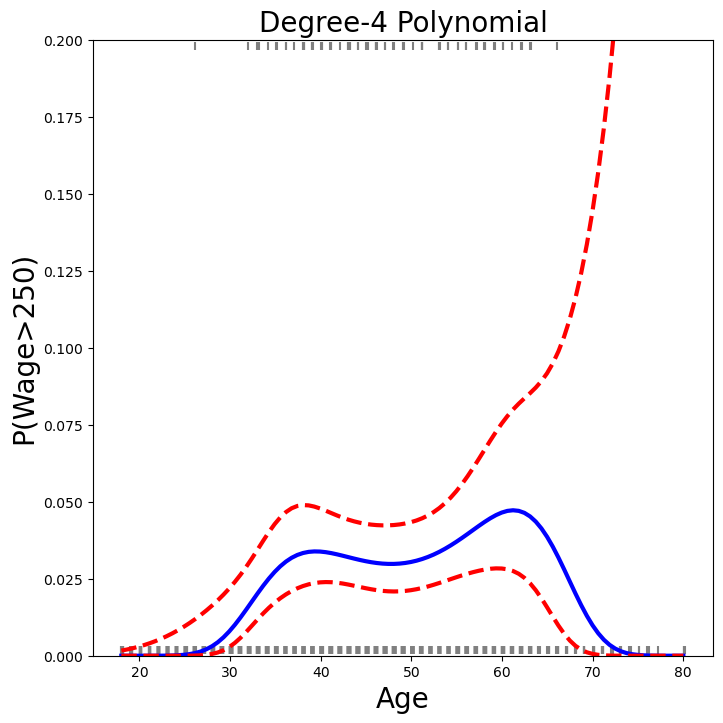

In [68]:
fig,ax=subplots(figsize=(8,8))
rng=np.random.default_rng(0)
ax.scatter(age + 
           0.2* rng.uniform (size=y.shape[0]),
           np.where(high_earn,0.198,0.002),
           fc='gray',
           marker='|')
for val,ls in zip([preds.predicted_mean,
                   bands[:,0],
                   bands[:,1]],
                   ['b','r--','r--']):
    ax.plot(age_df.values,val,ls,linewidth=3)
ax.set_title('Degree-4 Polynomial',fontsize=20)
ax.set_xlabel('Age',fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage>250)',fontsize=20);
                            

In [70]:
cut_age=pd.qcut(age,4)
summarize(sm.OLS(y,pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


#### Spline

In [73]:
bs_=BSpline(internal_knots=[25,40,60],intercept=True).fit(age)
bs_age=bs_.transform(age)
bs_age.shape

(3000, 7)

In [75]:
bs_age=MS([bs('age',internal_knots=[25,40,60])])
Xbs=bs_age.fit_transform(Wage)
M=sm.OLS(y,Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [77]:
bs_age=MS([bs('age',
              internal_knots=[25,40,60],
              name='bs(age)')])
Xbs=bs_age.fit_transform(Wage)
M=sm.OLS(y,Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [79]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [81]:
bs_age0=MS([bs('age',
                df=3,
                degree=0)]).fit(Wage)
Xbs0=bs_age0.transform(Wage)
summarize(sm.OLS(y,Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [83]:
ns_age=MS([ns('age',df=5)]).fit(Wage)
M_ns=sm.OLS(y,ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


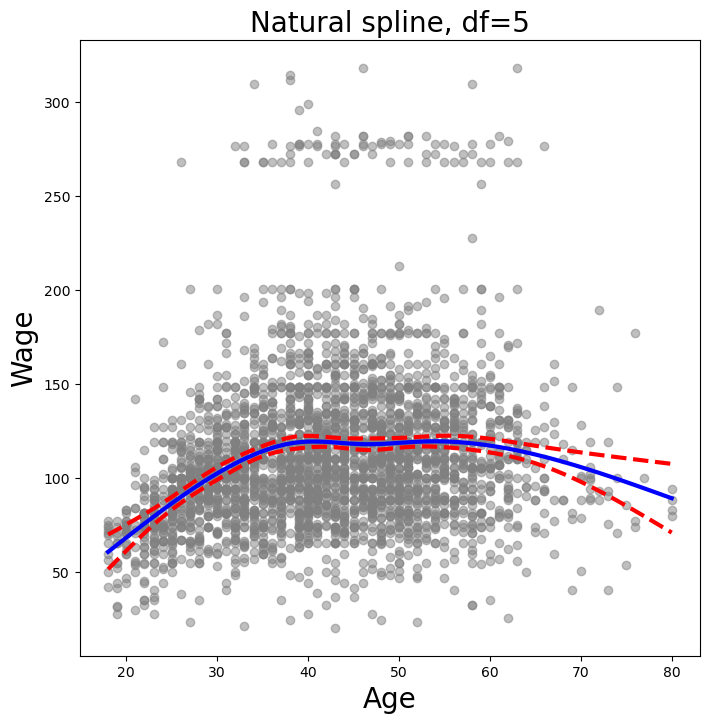

In [85]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5');

#### Smoothing Splines and GAMs`

In [88]:
X_age=np.array(age).reshape((-1,1))
gam=LinearGAM(s_gam(0,lam=0.6))
gam.fit(X_age,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

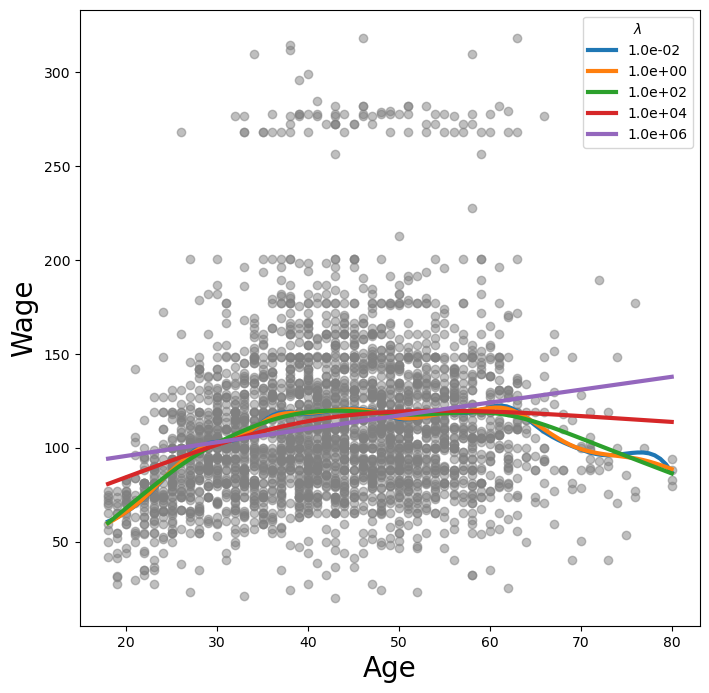

In [90]:
fig,ax=subplots(figsize=(8,8))
ax.scatter(age,y,facecolor='gray',alpha=0.5)
for lam in np.logspace(-2,6,5):
    gam=LinearGAM(s_gam(0,lam=lam)).fit(X_age,y)
    ax.plot(age_grid,
    gam.predict(age_grid),
    label='{:.1e}'.format(lam),
    linewidth=3)
ax.set_xlabel('Age',fontsize=20)
ax.set_ylabel('Wage',fontsize=20);
ax.legend(title=r'$\lambda$');

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


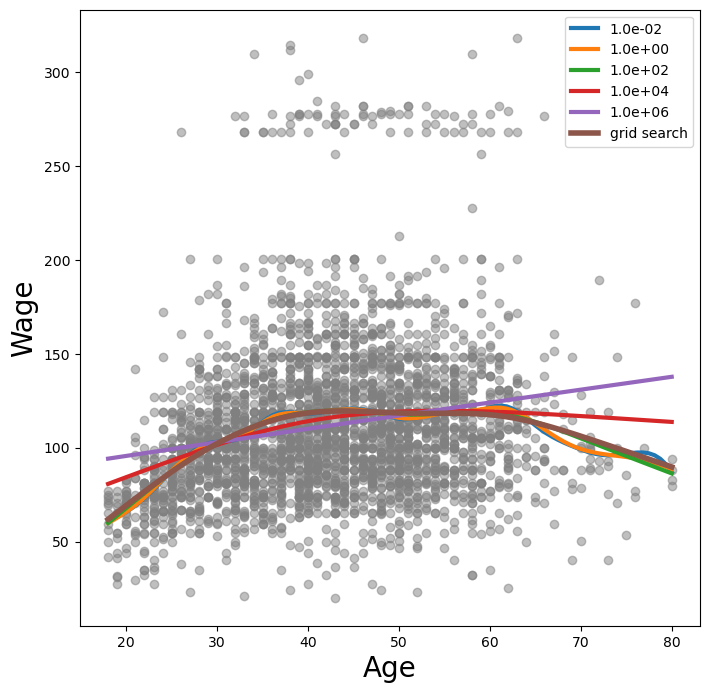

In [91]:
from pygam import LinearGAM,s
gam_opt = LinearGAM(s(0)).gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='grid search',
        linewidth=4)
ax.legend()
fig

In [92]:
age_term=gam.terms[0]
lam_4=approx_lam(X_age,age_term,4)
age_term.lam=lam_4
degrees_of_freedom(X_age,age_term)

4.000000099780289

NameError: name 'X_age' is not defined

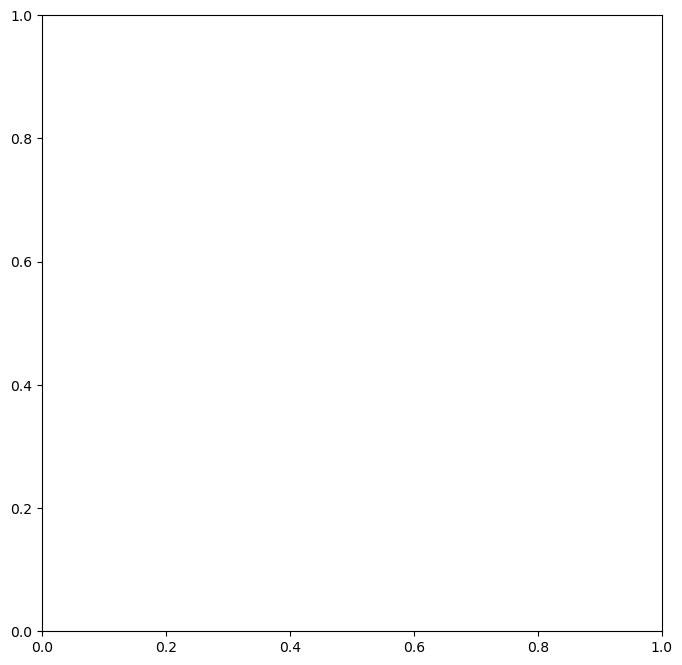

In [25]:
fig,ax=subplots(figsize=(8,8))
ax.scatter(X_age,
           y,facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam=approx_lam(X_age,age_term,df+1)
    age_term.lam=lam
    gam.fit(X_age,y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age',fontsize=20)
ax.set_ylabel('Wage',fontsize=20);
ax.legend(title='degree of freedom');

#### Additive Model with Several Terms

In [96]:
ns_age=NaturalSpline(df=4).fit(age)
ns_year=NaturalSpline(df=5).fit(Wage['year'])
Xs=[ns_age.transform(age),
    ns_year.transform(Wage['year']),
    pd.get_dummies(Wage['education']).values]
X_bh=np.hstack(Xs)
gam_bh=sm.OLS(y,X_bh).fit()

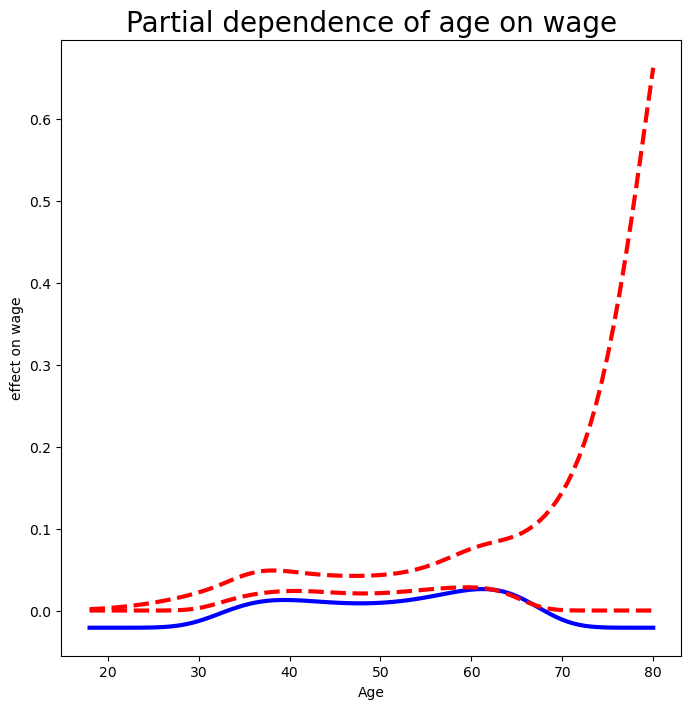

In [110]:
age_grid=np.linspace(age.min(),
                     age.max(),
                     100)
X_age_bh=X_bh.copy()[:100]
X_age_bh[:]=X_bh[:].mean(0)[None,:]
X_age_bh=gam_bh.get_prediction(X_age_bh)
bound_age=preds.conf_int(alpha=0.05)
partial_age=preds.predicted_mean
center=partial_age.mean()
partial_age-=center
bound_age-=center
fix,ax=subplots(figsize=(8,8))
ax.plot(age_grid,partial_age,'b',linewidth=3)
ax.plot(age_grid,bound_age[:,0],'r--',linewidth=3)
ax.plot(age_grid,bound_age[:,1],'r--',linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('effect on wage')
ax.set_title('Partial dependence of age on wage',fontsize=20);

Text(0.5, 1.0, 'Partial dependence of year on wage ')

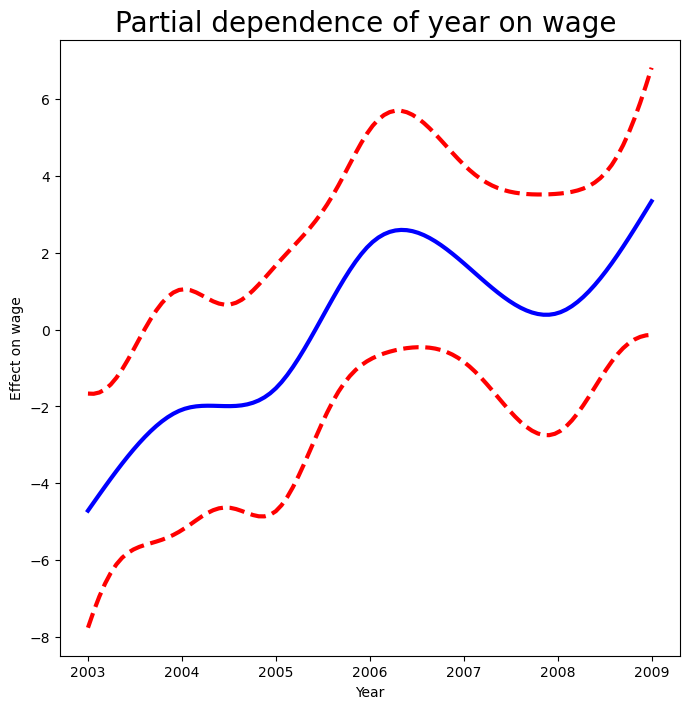

In [112]:
year_grid=np.linspace(2003,2009,100)
year_grid=np.linspace(wage['year'].min(),
                      wage['year'].max(),
                      100)
X_year_bh=X_bh.copy()[:100]
X_year_bh[:]=X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9]=ns_year.transform(year_grid)
preds=gam_bh.get_prediction(X_year_bh)
bounds_year=preds.conf_int(alpha=0.05)
partial_year=preds.predicted_mean
center=partial_year.mean()
partial_year-=center
bounds_year-=center
fig,ax=subplots(figsize=(8,8))
ax.plot(year_grid,partial_year,'b',linewidth=3)
ax.plot(year_grid,bounds_year[:,0],'r--',linewidth=3)
ax.plot(year_grid,bounds_year[:,1],'r--',linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage ', fontsize=20)

In [114]:
gam_full=LinearGAM(s_gam(0)+
                   s_gam(1,n_splines=7)+
                         f_gam(2,lam=0))
Xgam=np.column_stack([age,
                      wage['year'],
                      wage['education'].cat.codes])
gam_full=gam_full.fit(Xgam,y)
                   

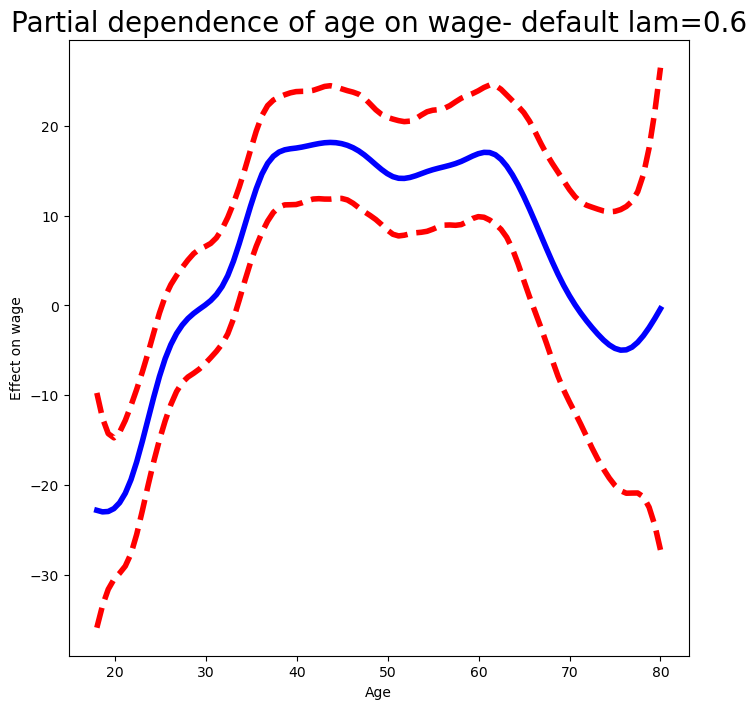

In [116]:
 fig, ax = subplots(figsize=(8,8))
 plot_gam(gam_full, 0, ax=ax)
 ax.set_xlabel('Age')
 ax.set_ylabel('Effect on wage')
 ax.set_title('Partial dependence of age on wage- default lam=0.6',
 fontsize=20);

In [120]:
 age_term = gam_full.terms[0]
 age_term.lam = approx_lam(Xgam, age_term, df=4+1)
 year_term = gam_full.terms[1]
 year_term.lam = approx_lam(Xgam, year_term, df=4+1)
 gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of year on wage')

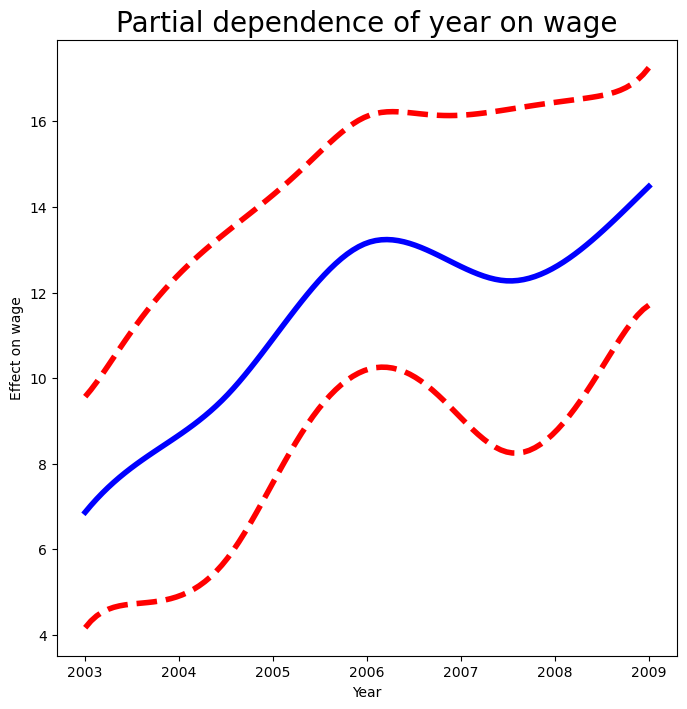

In [124]:
 fig, ax = subplots(figsize=(8,8))
 plot_gam(gam_full,
 1,
 ax=ax)
 ax.set_xlabel('Year')
 ax.set_ylabel('Effect on wage')
 ax.set_title('Partial dependence of year on wage', fontsize=20)

C:\Users\acer\AppData\Local\Temp\ipykernel_4500\1744998483.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);


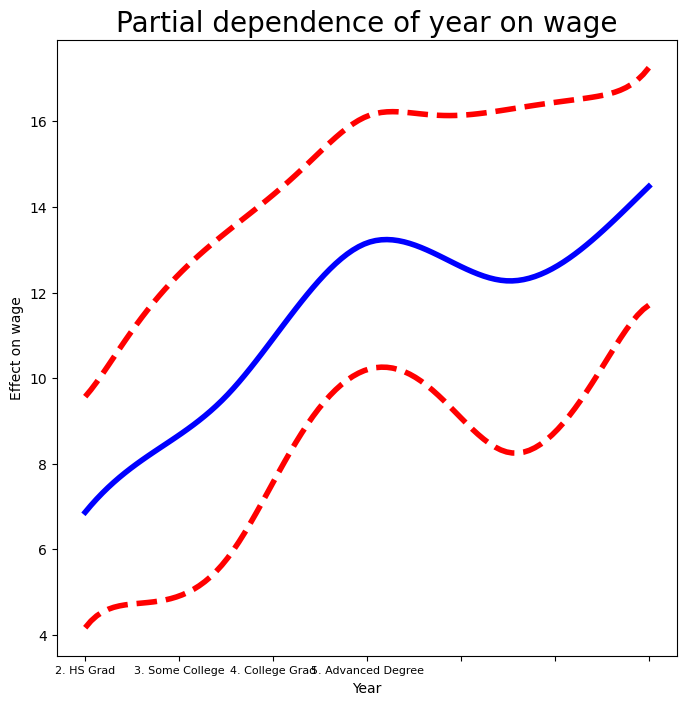

In [128]:
 fig, ax = subplots(figsize=(8,8))
 plot_gam(gam_full,
 1,
 ax=ax)
 ax.set_xlabel('Year')
 ax.set_ylabel('Effect on wage')
 ax.set_title('Partial dependence of year on wage', fontsize=20)
 ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

<h4>ANOVA Test for Additive Models</h4>

In [135]:
 gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
 gam_0.fit(Xgam, y)
 gam_linear = LinearGAM(age_term +
 l_gam(1, lam=0) +
 f_gam(2, lam=0))
 gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [137]:
 anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [139]:
 gam_0 = LinearGAM(year_term +
 f_gam(2, lam=0))
 gam_linear = LinearGAM(l_gam(0, lam=0) +
 year_term +
 f_gam(2, lam=0))
 gam_0.fit(Xgam, y)
 gam_linear.fit(Xgam, y)
 anova_gam(gam_0, gam_linear, gam_full)


,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [141]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\acer\AppData\Local\Temp\ipykernel_4500\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [143]:
Yhat = gam_full.predict(Xgam)

In [145]:
 gam_logit = LogisticGAM(age_term +
 l_gam(1, lam=0) +
 f_gam(2, lam=0))
 gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

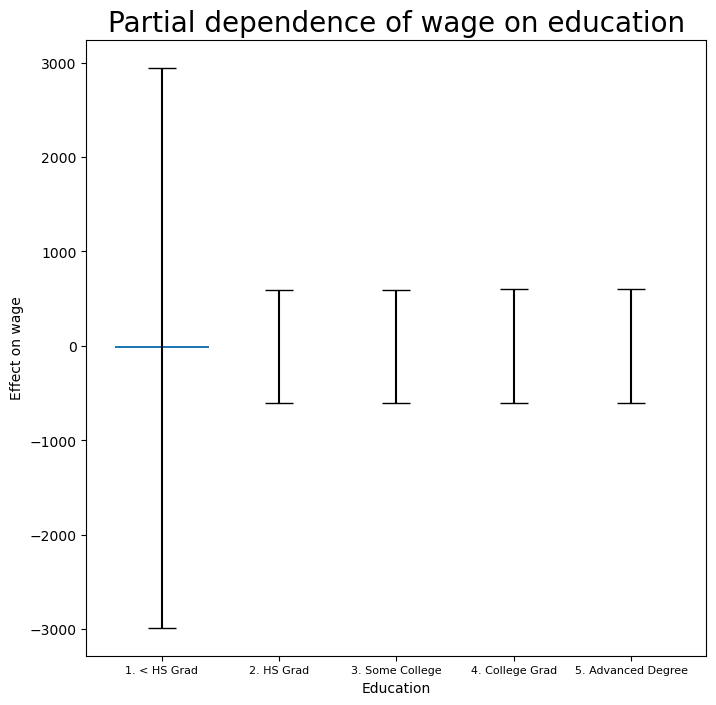

In [147]:
 fig, ax = subplots(figsize=(8, 8))
 ax = plot_gam(gam_logit, 2)
 ax.set_xlabel('Education')
 ax.set_ylabel('Effect on wage')
 ax.set_title('Partial dependence of wage on education',
 fontsize=20);
 ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

In [149]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [155]:
 only_hs = Wage['education'] == '1. < HS Grad'
 Wage_ = Wage.loc[ only_hs]
 Xgam_ = np.column_stack([Wage_['age'],
 Wage_['year'],
 Wage_['education'].cat.codes-1])
 high_earn_ = Wage_['high_earn']

In [157]:
 gam_logit_ = LogisticGAM(age_term +
 year_term +
 f_gam(2, lam=0))
 gam_logit_.fit(Xgam_, high_earn_)

C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\pygam\pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2['explained_deviance'] = 1.0 - full_d.sum() / null_d.sum()
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\pygam\pygam.py:1151: RuntimeWarning: divide by zero encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\pygam\pygam.py:1152: RuntimeWarning: divide by zero encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

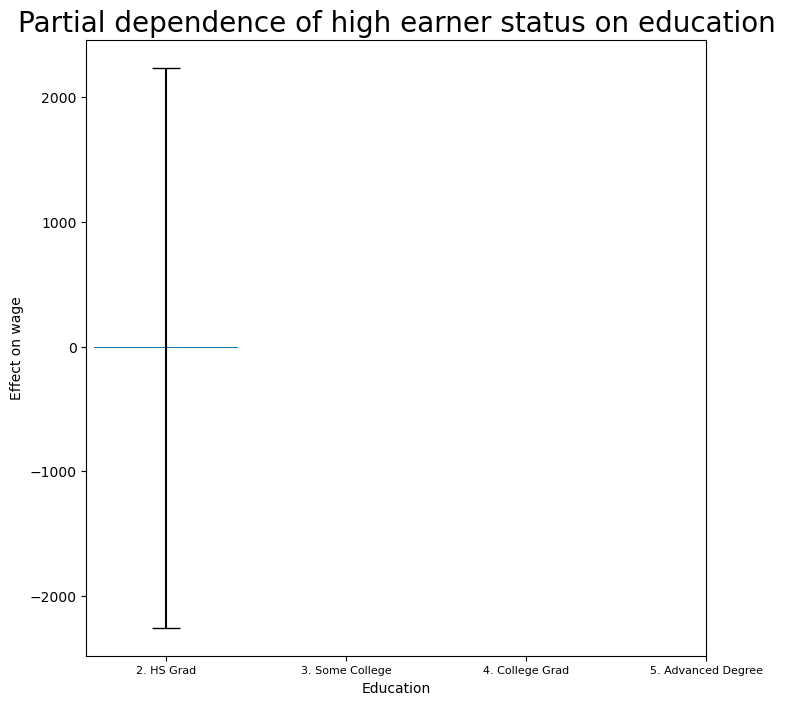

In [163]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20)

# Fix: set both tick positions and tick labels
categories = Wage['education'].cat.categories[1:]
tick_positions = range(len(categories))

ax.set_xticks(tick_positions)
ax.set_xticklabels(categories, fontsize=8)


ValueError: X data is out of domain for categorical feature 2. Expected data on [-1.0, -1.0], but found data on [0.0, 0.0]

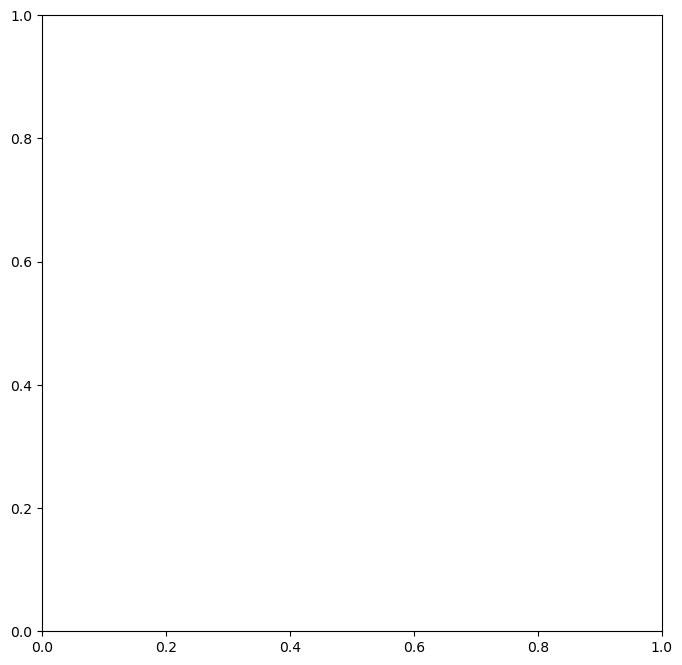

In [171]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)  # plot Year if it's term 0
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year', fontsize=20)


ValueError: X data is out of domain for categorical feature 2. Expected data on [-1.0, -1.0], but found data on [0.0, 0.0]

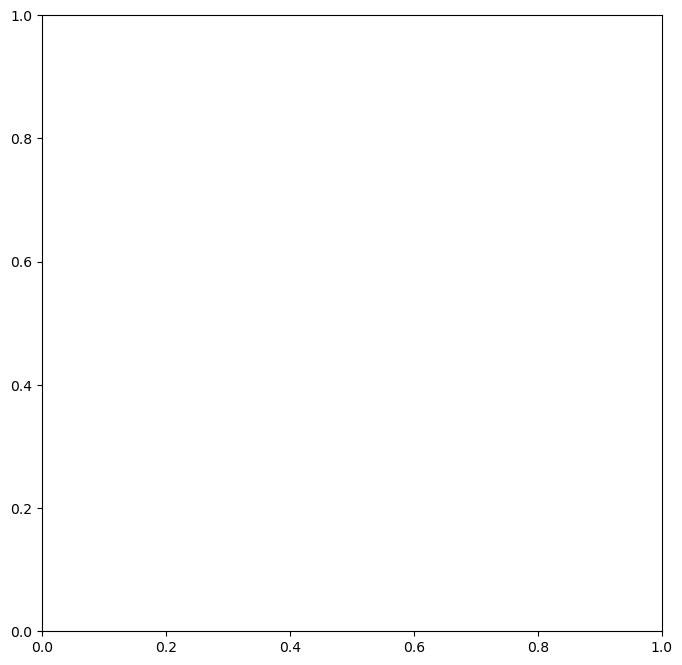

In [173]:
 fig, ax = subplots(figsize=(8, 8))
 ax = plot_gam(gam_logit_, 0)
 ax.set_xlabel('Age')
 ax.set_ylabel('Effect on wage')
 ax.set_title('Partial dependence of high earner status on age',
 fontsize=20);

<h4>Local Regression</h4>

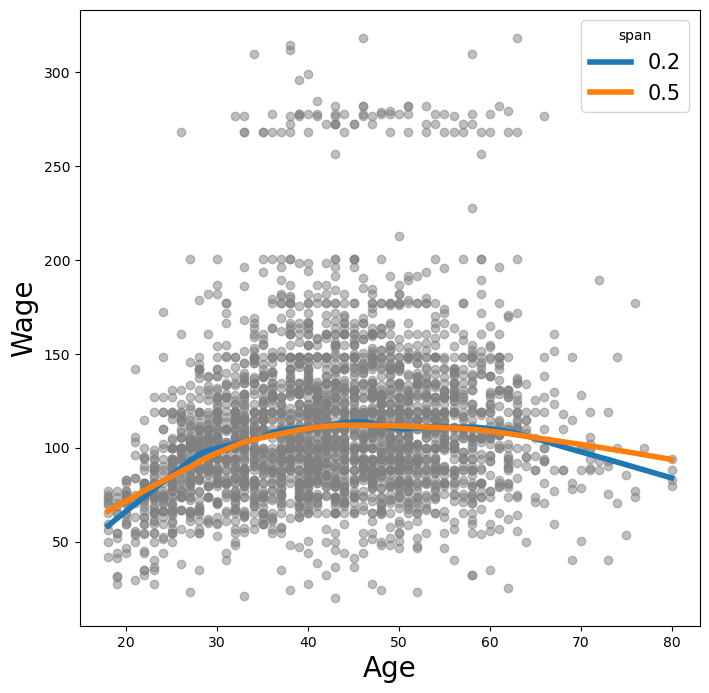

In [180]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
 fitted = lowess(y,
                 age,frac=span,
                 xvals=age_grid)
 ax.plot(age_grid,
              fitted,
              label='{:.1f}'.format(span),
              linewidth=4)

ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);    
